<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_RARE_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt
!pip install ismrmrd

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

In [2]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

(RARE_2D_seq)=
# 2D RARE

In [ ]:
def seq_RARE_2D(
    fov=(200e-3, 200e-3, 8e-3),
    Nread=96,
    Nphase=96,
    Npart=1,
    FA=torch.tensor(90 * np.pi / 180),
    FA_ref=torch.tensor(180 * np.pi / 180),
    TE=torch.tensor(5e-3),
    slice_thickness=8e-3,
    experiment_id='RARE_2D',
    system=None,
    # RARE-specific parameters
    TI_s=0,  # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
    r_spoil=2,  # @param {type: "slider", min: 0, max: 3}
    PE_grad_on=True,  # @param {type: "boolean"}
    RO_grad_on=True,  # @param {type: "boolean"}
    dwell=50e-6*2
):
    """
    2D RARE sequence function following MRzero standard.
    
    Args:
        fov: tuple of floats (x, y, z) in meters
        Nread: int - frequency encoding steps
        Nphase: int - phase encoding steps
        Npart: int - number of partitions
        FA: tensor - excitation flip angle
        FA_ref: tensor - refocusing flip angle
        TE: tensor - echo time
        slice_thickness: float - slice thickness
        experiment_id: string - experiment identifier
        system: optional scanner system limits
        verbose: bool - verbose output
        TI_s: float - inversion time in seconds
        r_spoil: int - spoiling factor
        PE_grad_on: bool - enable phase encoding gradients
        RO_grad_on: bool - enable readout gradients
        dwell: float - ADC dwell time
    
    Returns:
        pp.Sequence: PyPulseq sequence object
    """
    # Choose the scanner limits
    if system is None:
        system = pp.Opts(
            max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
            rf_ringdown_time=20e-6, rf_dead_time=100e-6,
            adc_dead_time=20e-6, grad_raster_time=10e-6
        )

    seq = pp.Sequence(system)
    
    G_flag = (int(RO_grad_on), int(PE_grad_on))  # gradient flag (read,PE)

    # Define RF events
    rf1, gz1, gzr1 = pp.make_sinc_pulse(
        flip_angle=FA.item(), phase_offset=90 * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)

    rf2, gz2, _ = pp.make_sinc_pulse(
        flip_angle=FA_ref.item(), duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', rise_time=0.5*dwell, flat_area=Nread / fov[0]*G_flag[0], 
                          flat_time=Nread*dwell, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180, 
                     delay=0*gx.rise_time, system=system)
    gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2), 
                               duration=1.5e-3, system=system)
    gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), 
                                    duration=1e-3, system=system)
    gp = pp.make_trapezoid(channel='y', area=0 / fov[1], duration=1e-3, system=system)
    rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)

    # FLAIR preparation
    if TI_s > 0:
        seq.add_block(rf_prep)
        seq.add_block(pp.make_delay(TI_s))
        seq.add_block(gx_pre0)

    seq.add_block(rf1, gz1)
    seq.add_block(gx_pre0, gzr1)

    # Calculate minimal TE
    minTE2 = (pp.calc_duration(gz2) + pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2
    minTE2 = round(minTE2/10e-5)*10e-5

    # Calculate TE delay
    TEd = round(max(0, (TE.item()/2 - minTE2))/10e-5)*10e-5  # round to raster time

    if TEd == 0:
        print('echo time set to minTE [ms]', 2*(minTE2 + TEd)*1000)
    else:
        print('TE [ms]', 2*(minTE2 + TEd)*1000)

    # Add delay between excitation and first ref pulse
    seq.add_block(pp.make_delay((minTE2 + TEd) - pp.calc_duration(gz1) - pp.calc_duration(gx_pre0)))

    # RARE echo train
    for ii in range(-Nphase // 2, Nphase // 2):  # e.g. -64:63
        gp = pp.make_trapezoid(channel='y', area=+ii / fov[1]*G_flag[1], duration=1e-3, system=system)
        gp_ = pp.make_trapezoid(channel='y', area=-ii / fov[1]*G_flag[1], duration=1e-3, system=system)

        seq.add_block(rf2, gz2)
        seq.add_block(pp.make_delay(TEd))  # TE delay
        seq.add_block(gx_prewinder, gp)
        seq.add_block(adc, gx)
        seq.add_block(gx_prewinder, gp_)
        seq.add_block(pp.make_delay(TEd))  # TE delay

    # Required sequence definitions
    seq.set_definition('name', experiment_id)
    seq.set_definition('fov', [fov[0], fov[1], fov[2]])
    seq.set_definition('matrix', [Nread, Nphase, Npart])
    
    return seq


C:\Users\alyar\AppData\Local\Temp\ipykernel_22296\2104663123.py:56: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, gz1, gzr1 = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_22296\2104663123.py:61: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf2, gz2, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_22296\2104663123.py:69: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180,
C:\Users\alyar\AppData\Local\Temp\ipykernel_22296\2104663123.py:76: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


echo time set to minTE [ms] 7.4
Timing check passed successfully
DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 43 / 43 - done


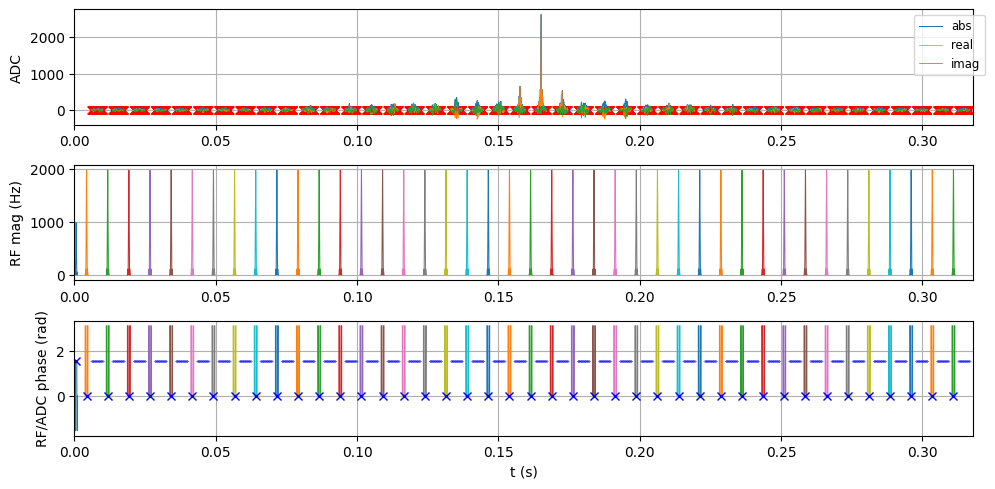

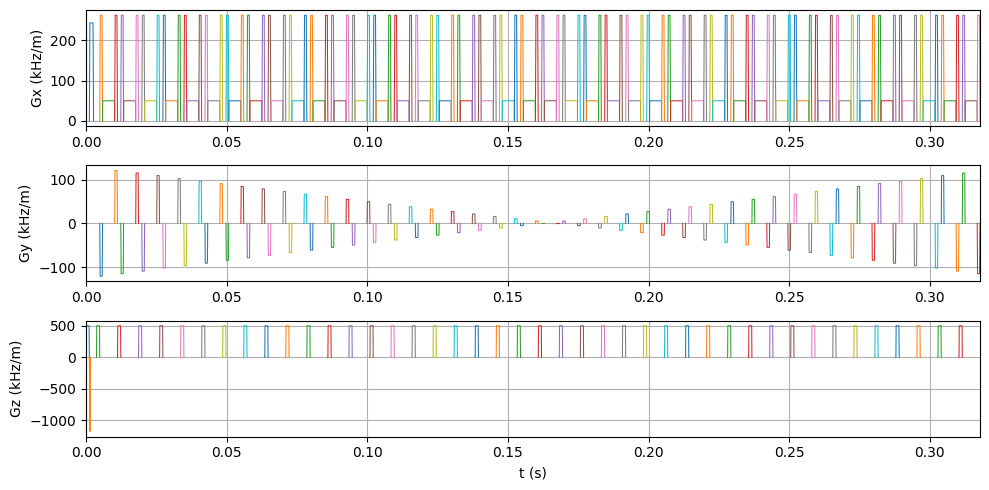

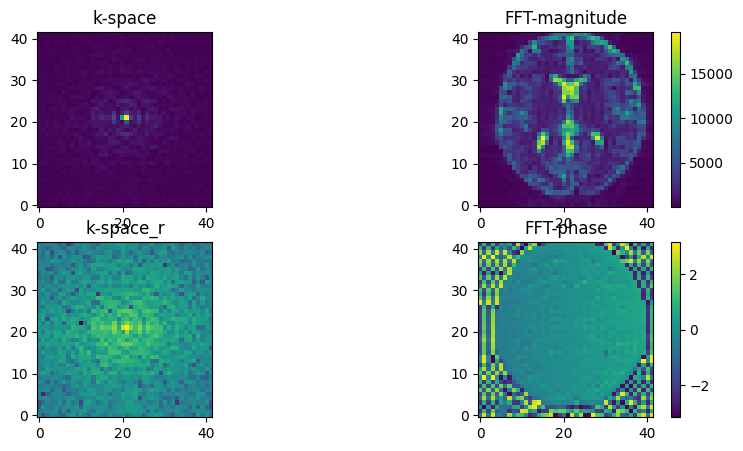

In [ ]:
#@title RARE

# Define parameters as plain variables
experiment_id = 'RARE_2D'
fov = (200e-3, 200e-3, 8e-3)
base_resolution = 42  # @param {type: "slider", min: 2, max: 112, step: 2}
Nread = base_resolution  # frequency encoding steps/samples
Nphase = base_resolution  # phase encoding steps/samples
Npart = 1
FA = 90  # @param {type: "slider", min: 10, max: 270}
FA_ref = 180 # @param {type: "slider", min: 10, max: 270}
TE_ms = 5  # @param {type: "slider", min: 0.0, max: 200.0}
TE = torch.tensor(TE_ms * 1e-3)
slice_thickness = 8e-3

# RARE-specific parameters
TI_s = 0  # @param {type: "slider", min: 0.0, max: 10.0, step: 0.1}
r_spoil = 2  # @param {type: "slider", min: 0, max: 3}
PE_grad_on = True  # @param {type: "boolean"}
RO_grad_on = True  # @param {type: "boolean"}
dwell = 50e-6 * 2

# Generate sequence using standard parameters
seq = seq_RARE_2D(
    fov=fov,
    Nread=Nread,
    Nphase=Nphase,
    Npart=Npart,
    FA=torch.tensor(FA * np.pi / 180),
    FA_ref=torch.tensor(FA_ref * np.pi / 180),
    TE=TE,
    slice_thickness=slice_thickness,
    experiment_id=experiment_id,
    TI_s=TI_s,
    r_spoil=r_spoil,
    PE_grad_on=PE_grad_on,
    RO_grad_on=RO_grad_on,
    dwell=dwell
)

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]
    
# %% S3 quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'TSE_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()
